In [1]:
#проект направлен на создание классификационной модели для определения состояния жд трансформаторов по значениям, полученных с датчиков
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
#import statsmodels.api as sm
import plotly.express as px
#import missingno as msno 
import lazypredict
import random as rd
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.utils import shuffle
from sklearn.svm import LinearSVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, GridSearchCV

from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
sns.set_style('darkgrid')
%matplotlib inline
from sklearn import tree

Предобработка

In [2]:
data = pd.read_csv('Health index2.csv')
data.head

<bound method NDFrame.head of      Hydrogen  Oxigen  Nitrogen  Methane   CO   CO2  Ethylene  Ethane  \
0        2845    5860     27842     7406   32  1344     16684    5467   
1       12886      61     25041      877   83   864         4     305   
2        2820   16400     56300      144  257  1080       206      11   
3        1099      70     37520      545  184  1402         6     230   
4        3210    3570     47900      160  360  2130         4      43   
..        ...     ...       ...      ...  ...   ...       ...     ...   
465        15     227     52900        3   60   853         3      84   
466        15     334     47100        3   64   622         3     108   
467        15    1280     35000        2  675  2530         0       0   
468        15     169     50600        5   77   532         0      72   
469        15     308     39700        3   64   581         5      27   

     Acethylene  DBDS  Power factor  Interfacial V  Dielectric rigidity  \
0             7 19

In [3]:
data.describe().T.sort_values(ascending = 0,by = "mean").style.background_gradient(cmap = "BuGn")

,count,mean,std,min,25%,50%,75%,max
Nitrogen,470.000000,47759.561702,13760.451816,3600.000000,41700.000000,49100.000000,55875.000000,85300.000000
Oxigen,470.000000,8357.372340,14164.233283,57.000000,496.000000,3810.000000,14875.000000,249900.000000
CO2,470.000000,1816.414894,2256.790519,48.000000,641.750000,1125.000000,2257.500000,24900.000000
Hydrogen,470.000000,404.261702,2002.142678,0.000000,4.000000,9.000000,34.000000,23349.000000
CO,470.000000,244.000000,237.267485,10.000000,66.000000,150.500000,361.750000,1730.000000
Ethylene,470.000000,162.923404,1323.811504,0.000000,0.000000,3.000000,6.000000,16684.000000
Acethylene,470.000000,91.491489,644.365828,0.000000,0.000000,0.000000,0.000000,9740.000000
Ethane,470.000000,81.940426,342.573636,0.000000,0.000000,4.000000,69.750000,5467.000000
Methane,470.000000,79.695745,489.320336,0.000000,2.000000,3.000000,7.000000,7406.000000
Dielectric rigidity,470.000000,53.495745,6.458906,27.000000,51.000000,54.000000,56.000000,75.000000


In [4]:
df = pd.DataFrame(data=data)
df

,Hydrogen,Oxigen,Nitrogen,Methane,CO,CO2,Ethylene,Ethane,Acethylene,DBDS,Power factor,Interfacial V,Dielectric rigidity,Water content,Health index
0,2845,5860,27842,7406,32,1344,16684,5467,7,19.00,1.00,45,55,0,95.20
1,12886,61,25041,877,83,864,4,305,0,45.00,1.00,45,55,0,85.50
2,2820,16400,56300,144,257,1080,206,11,2190,1.00,1.00,39,52,11,85.30
3,1099,70,37520,545,184,1402,6,230,0,87.00,4.58,33,49,5,85.30
4,3210,3570,47900,160,360,2130,4,43,4,1.00,0.77,44,55,3,85.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,15,227,52900,3,60,853,3,84,0,0.00,1.00,32,56,28,13.40
466,15,334,47100,3,64,622,3,108,0,0.00,1.00,32,55,12,13.40
467,15,1280,35000,2,675,2530,0,0,0,5.00,0.30,45,58,8,13.40
468,15,169,50600,5,77,532,0,72,0,0.00,1.21,33,54,11,13.40


Делаем из регрессии классификацию. Создаем столбец Condition, в котором хранится состояния объекта, исходя из столбца Health index.

In [5]:
Condition = []
for row in df['Health index']:
    if row > 85 and row <=100:
        Condition.append('Very Good')
    elif row > 70 and row <=85:
        Condition.append('Good')
    elif row > 50 and row <=70:
        Condition.append('Fair')
    elif row > 30 and row <=50:
        Condition.append('Poor')
    elif row >=0 and row <=30:
        Condition.append('Very Poor')
    else:
        Condition.append(Nan)

In [6]:
df['Condition'] = Condition
df

,Hydrogen,Oxigen,Nitrogen,Methane,CO,CO2,Ethylene,Ethane,Acethylene,DBDS,Power factor,Interfacial V,Dielectric rigidity,Water content,Health index,Condition
0,2845,5860,27842,7406,32,1344,16684,5467,7,19.00,1.00,45,55,0,95.20,Very Good
1,12886,61,25041,877,83,864,4,305,0,45.00,1.00,45,55,0,85.50,Very Good
2,2820,16400,56300,144,257,1080,206,11,2190,1.00,1.00,39,52,11,85.30,Very Good
3,1099,70,37520,545,184,1402,6,230,0,87.00,4.58,33,49,5,85.30,Very Good
4,3210,3570,47900,160,360,2130,4,43,4,1.00,0.77,44,55,3,85.20,Very Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,15,227,52900,3,60,853,3,84,0,0.00,1.00,32,56,28,13.40,Very Poor
466,15,334,47100,3,64,622,3,108,0,0.00,1.00,32,55,12,13.40,Very Poor
467,15,1280,35000,2,675,2530,0,0,0,5.00,0.30,45,58,8,13.40,Very Poor
468,15,169,50600,5,77,532,0,72,0,0.00,1.21,33,54,11,13.40,Very Poor


In [7]:
df.drop(columns=['Health index'],axis=1,inplace=True)

In [8]:
df['Condition'].value_counts()

Very Poor    285
Poor         135
Fair          41
Very Good      5
Good           4
Name: Condition, dtype: int64

In [9]:
df

,Hydrogen,Oxigen,Nitrogen,Methane,CO,CO2,Ethylene,Ethane,Acethylene,DBDS,Power factor,Interfacial V,Dielectric rigidity,Water content,Condition
0,2845,5860,27842,7406,32,1344,16684,5467,7,19.00,1.00,45,55,0,Very Good
1,12886,61,25041,877,83,864,4,305,0,45.00,1.00,45,55,0,Very Good
2,2820,16400,56300,144,257,1080,206,11,2190,1.00,1.00,39,52,11,Very Good
3,1099,70,37520,545,184,1402,6,230,0,87.00,4.58,33,49,5,Very Good
4,3210,3570,47900,160,360,2130,4,43,4,1.00,0.77,44,55,3,Very Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,15,227,52900,3,60,853,3,84,0,0.00,1.00,32,56,28,Very Poor
466,15,334,47100,3,64,622,3,108,0,0.00,1.00,32,55,12,Very Poor
467,15,1280,35000,2,675,2530,0,0,0,5.00,0.30,45,58,8,Very Poor
468,15,169,50600,5,77,532,0,72,0,0.00,1.21,33,54,11,Very Poor


In [10]:
df.to_excel('Heath index.xlsx')

<Axes: xlabel='Condition', ylabel='Count'>

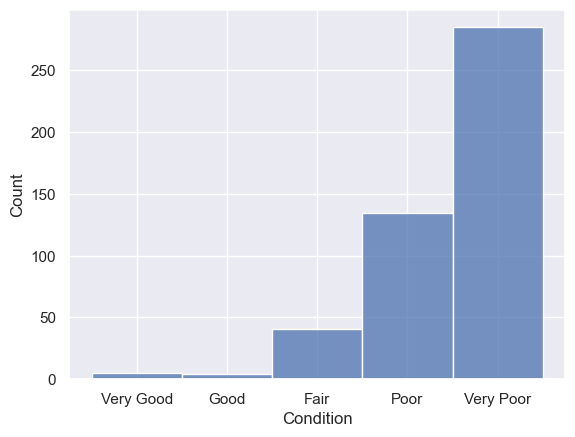

In [11]:
sns.set_theme(style='darkgrid')
sns.histplot(x='Condition',data=df,stat='count',bins=10)

Обучение моделей

In [12]:
y = df.loc[:, 'Condition'].copy()
x = df.loc[:, [i for i in df.columns if i != 'Condition']].copy()

In [13]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x = sc.fit_transform(x)

In [14]:
from imblearn.over_sampling import RandomOverSampler
over=RandomOverSampler()
x,y=over.fit_resample(x,y)

In [15]:
x.shape

(1425, 14)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2)

In [17]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric = None,classifiers = 'all')
models_class, predictions_class = clf.fit(x_train, x_test, y_train, y_test)

100%|██████████| 29/29 [00:01<00:00, 16.57it/s]


In [18]:
models_class

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.96,0.96,None,0.96,0.18
ExtraTreesClassifier,0.95,0.96,None,0.95,0.11
LGBMClassifier,0.95,0.96,None,0.95,0.28
BaggingClassifier,0.95,0.95,None,0.95,0.04
LabelPropagation,0.95,0.95,None,0.95,0.04
LabelSpreading,0.95,0.95,None,0.95,0.05
ExtraTreeClassifier,0.94,0.95,None,0.94,0.01
DecisionTreeClassifier,0.94,0.95,None,0.94,0.01
KNeighborsClassifier,0.89,0.90,None,0.89,0.02


In [19]:
models_class.sort_values(by = 'Accuracy',inplace = True)
line = px.line(data_frame= models_class ,y =["Accuracy"] , markers = True)
#line.update_xaxes(title="Модель")
line.update_yaxes(title = "Точность")
line.update_traces(line_color="red")
line.update_layout(showlegend = True, title = {'text': 'Точность моделей'})

line.show()

Используем Random forest

In [25]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [26]:
y_pred = rfc.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print(acc)

0.9614035087719298


In [27]:
import joblib
joblib.dump(rfc, "./random_forest.joblib")

['./random_forest.joblib']

Поиск оптимальных гиперпараметров через RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rfc_test = RandomForestClassifier()
crossvalidation=KFold(n_splits=10,shuffle=True,random_state=1)
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 3)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 7)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 7)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfc_test, 
                        param_dist, 
                        n_iter = 100, 
                        cv = crossvalidation, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(x_train, y_train)
rs.best_params_

In [22]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df

NameError: name 'rs' is not defined

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.83,.93])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.85,.93])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.80,.93])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.88,.92])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.80,.93])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.88,.92])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

In [24]:
from sklearn.ensemble import RandomForestClassifier
rfc_test_2 = RandomForestClassifier(n_estimators = 800, min_samples_split= 2, min_samples_leaf= 2, max_features='sqrt', max_depth= 15, bootstrap= True)
rfc_test_2.fit(x_train, y_train)
rfc_test_2.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [25]:
y_pred = rfc_test_2.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print(acc)

0.9578947368421052


Поиск оптимальных гиперпараметров через GridSearchCV

In [26]:
from sklearn.ensemble import RandomForestClassifier
rfc_test = RandomForestClassifier()

In [ ]:
from sklearn.model_selection import GridSearchCV
n_estimators = [200, 350, 500, 700]
max_features = ['sqrt', 'log2']
max_depth = [2, 6, 10, 14, 20]
min_samples_split = [2, 8, 14, 20, 30]
min_samples_leaf = [2, 8, 14, 20, 30]
bootstrap = [False, True]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(rfc_test, param_grid, cv = crossvalidation, verbose = 1, n_jobs=-1)
gs.fit(x_train, y_train)
rfc_3 = gs.best_estimator_
gs.best_params_

Fitting 10 folds for each of 2000 candidates, totalling 20000 fits


{'bootstrap': False,
 'max_depth': 14,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 350}

In [ ]:
rs_df = pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df

,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,rank_test_score
0,False,20,sqrt,2,2,700,0.98,0.98,0.91,0.96,0.97,0.96,0.96,0.96,1
1,False,14,log2,2,2,350,0.97,0.98,0.92,0.96,0.97,0.97,0.96,0.96,1
2,False,20,log2,2,2,200,0.97,0.98,0.90,0.96,0.97,0.97,0.97,0.96,3
3,False,14,sqrt,2,2,350,0.97,0.98,0.90,0.96,0.97,0.96,0.98,0.96,4
4,False,20,log2,2,8,350,0.97,0.98,0.91,0.96,0.97,0.97,0.96,0.96,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,False,2,sqrt,14,14,500,0.83,0.84,0.64,0.78,0.75,0.82,0.79,0.77,1994
1996,False,2,log2,20,30,200,0.76,0.89,0.65,0.78,0.81,0.82,0.78,0.77,1997
1997,False,2,log2,20,14,350,0.83,0.85,0.65,0.77,0.75,0.80,0.79,0.77,1997
1998,False,2,sqrt,8,8,200,0.83,0.88,0.65,0.77,0.75,0.78,0.79,0.77,1999


In [21]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap = False, max_depth = 14,max_features = 'log2',min_samples_leaf = 2,min_samples_split = 2,n_estimators = 350)
rfc.fit(x_train, y_train)
rfc.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 14,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 350,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [22]:
y_pred = rfc.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print(acc)

0.9649122807017544


In [ ]:
y_test = list(y_test)

In [ ]:
df_result = pd.DataFrame()
df_result['Predict y'] = y_pred
df_result['True y'] = y_test

In [ ]:
df_result

,Predict y,True y
0,Poor,Poor
1,Very Good,Very Good
2,Very Poor,Very Poor
3,Very Good,Very Good
4,Poor,Poor
...,...,...
280,Poor,Very Poor
281,Fair,Fair
282,Fair,Fair
283,Poor,Poor


In [ ]:
df_result.to_excel('Result training classification.xlsx')